In [1]:
#Importiamo le librerie utili
import time
import numpy as np
import scipy.stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)  # sometimes this is required to enable logging inside Jupyter
%matplotlib inline
%precision 2

import elfi

#Prendiamo un seed arbitrario per riproducibilità dei risultati
seed = 20220530
np.random.seed(seed)

#Parametro reale
t1_true = 0

In [2]:
#Definiamo il modello
def TOY(t1, n_obs=100, batch_size=1, random_state=None):
    t1 = np.asanyarray(t1).reshape((-1, 1))
    random_state = random_state or np.random
    n1 = np.random.normal(loc=t1, scale=1.0, size=(batch_size,10))
    n2 = np.random.normal(loc=t1, scale=0.01, size=(batch_size,10))
    x = 0.5*n1 + 0.5*n2
    return x

#OPPURE
def gaussian_mixture(theta, batch_size=1, random_state=None):
    sigma1 = 1
    sigma2 = np.sqrt(0.05)
    sigmas = np.array((sigma1, sigma2))
    mixture_prob = 0.5
    random_state = random_state or np.random
    scale_array = random_state.choice(sigmas,
                                      size=batch_size,
                                      replace=True,
                                      p=np.array((mixture_prob, 1-mixture_prob)))
    observation = scipy.stats.norm.rvs(loc=theta,
                              scale=scale_array,
                              size=batch_size,
                              random_state=random_state)
    return observation

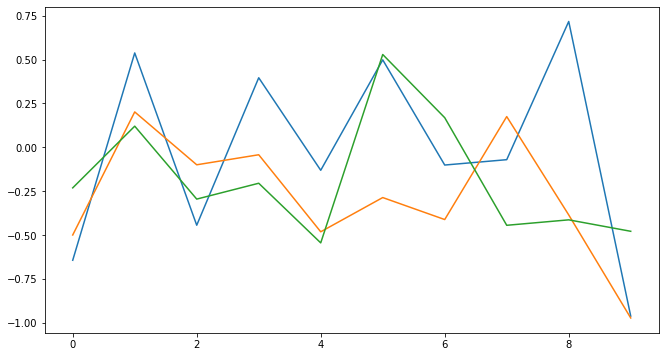

In [3]:
#Valori ottenuti con il parametro reale
y_obs = TOY(t1_true)

#Plottiamo i dati
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel());

#Illustriamo la stocasticità simulando altre due volte
plt.plot(TOY(t1_true).ravel());
plt.plot(TOY(t1_true).ravel());

In [4]:
#Settiamo una priori uniforme
t1 = elfi.Prior(scipy.stats.uniform, -10, 20)

In [5]:
#Definiamo il nodo simulatore di elfi, basato su prior e modello
Y = elfi.Simulator(TOY, t1, observed=y_obs)

In [6]:
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

In [7]:
#Definiamo i nodi summary di elfi
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)  # the optional keyword lag is given the value 2

In [8]:
#Concludiamo il modello con la definizione euclidea di distanza
d = elfi.Distance('euclidean', S1, S2)

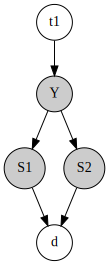

In [9]:
#Controlliamo tramite l'utilizzo di Graphviz la corretta struttura dei nodi scelti
elfi.draw(d)

In [10]:
#Sequential Monte Carlo
smc = elfi.SMC(d, batch_size=1000, seed=seed)

In [11]:
N = 1000
schedule = [5, 1, 0.01]
%time result_smc = smc.sample(N, schedule)

INFO:elfi.methods.inference.samplers:---------------- Starting round 0 ----------------


ABC-SMC Round 1 / 3


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:elfi.methods.inference.samplers:---------------- Starting round 1 ----------------


Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 3
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.samplers:---------------- Starting round 2 ----------------


ABC-SMC Round 3 / 3
Progress [==================================================] 100.0% Complete
Wall time: 1min 32s


In [12]:
result_smc.summary(all=True)

Method: SMC
Number of samples: 1000
Number of simulations: 7343000
Threshold: 0.00999
Sample means: t1: -0.00568

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 6000
Threshold: 3.7
Sample means: t1: -0.0289

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 3000
Threshold: 0.781
Sample means: t1: 0.0265

Population 2:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 7334000
Threshold: 0.00999
Sample means: t1: -0.00568


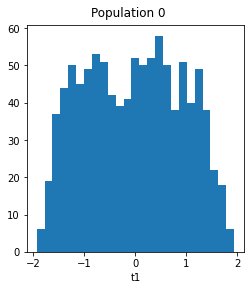

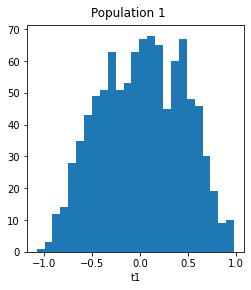

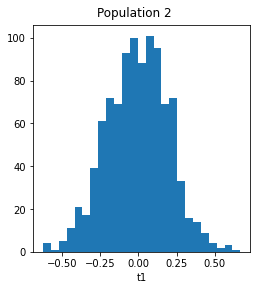

In [13]:
result_smc.plot_marginals(all=True, bins=25, figsize=(8, 2), fontsize=12)

In [14]:
#A questo punto proviamo dei metodi adattivi per migliorare l'efficienza di Sequential Monte Carlo

In [15]:
#Sequential Monte Carlo con soglia adattiva
adaptive_smc = elfi.AdaptiveThresholdSMC(d, batch_size=500, seed=seed, q_threshold=0.99975)
adaptive_smc_samples = adaptive_smc.sample(1000, max_iter=5)

INFO:elfi.methods.inference.samplers:---------------- Starting round 0 ----------------
INFO:elfi.methods.inference.samplers:ABC-SMC: Adapting quantile threshold...


ABC-SMC Round 1 / 5
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.samplers:ABC-SMC: Estimated maximum density ratio 0.21066
INFO:elfi.methods.inference.samplers:---------------- Starting round 1 ----------------
INFO:elfi.methods.inference.samplers:ABC-SMC: Selected threshold for next population 0.367


ABC-SMC Round 2 / 5
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.samplers:ABC-SMC: Adapting quantile threshold...
INFO:elfi.methods.inference.samplers:ABC-SMC: Estimated maximum density ratio 0.29879
INFO:elfi.methods.inference.samplers:---------------- Starting round 2 ----------------
INFO:elfi.methods.inference.samplers:ABC-SMC: Selected threshold for next population 0.210


ABC-SMC Round 3 / 5
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.samplers:ABC-SMC: Adapting quantile threshold...
INFO:elfi.methods.inference.samplers:ABC-SMC: Estimated maximum density ratio 0.88584
INFO:elfi.methods.inference.samplers:---------------- Starting round 3 ----------------
INFO:elfi.methods.inference.samplers:ABC-SMC: Selected threshold for next population 0.202


ABC-SMC Round 4 / 5
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.samplers:ABC-SMC: Adapting quantile threshold...
INFO:elfi.methods.inference.samplers:ABC-SMC: Estimated maximum density ratio 0.96822
INFO:elfi.methods.inference.samplers:---------------- Starting round 4 ----------------
INFO:elfi.methods.inference.samplers:ABC-SMC: Selected threshold for next population 0.198


ABC-SMC Round 5 / 5
Progress [==================================================] 100.0% Complete


In [16]:
adaptive_smc_samples.summary(all=True)

Method: AdaptiveThresholdSMC
Number of samples: 1000
Number of simulations: 27500
Threshold: 0.197
Sample means: t1: 0.00874

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 5000
Threshold: 5.14
Sample means: t1: -0.0216

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 6000
Threshold: 0.361
Sample means: t1: 0.00381

Population 2:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 5500
Threshold: 0.21
Sample means: t1: 0.00628

Population 3:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 5500
Threshold: 0.199
Sample means: t1: -0.00517

Population 4:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 5500
Threshold: 0.197
Sample means: t1: 0.00874


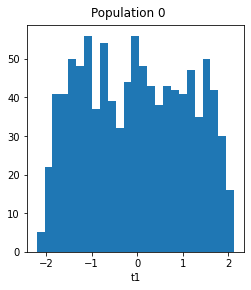

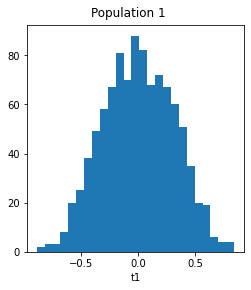

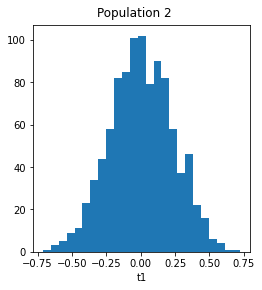

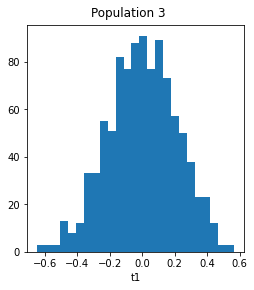

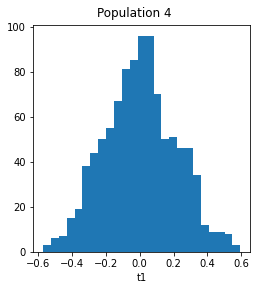

In [17]:
adaptive_smc_samples.plot_marginals(all=True, bins=25, figsize=(8, 2), fontsize=12)

In [18]:
#Posteriori teorica
def gaussian_mixture_density(theta, sigma_1=1, sigma_2=0.1):
    y = 0.5 * scipy.stats.norm.pdf(theta, loc=0, scale=sigma_1) + 0.5 * scipy.stats.norm.pdf(theta, loc=0, scale=sigma_2)
    return y

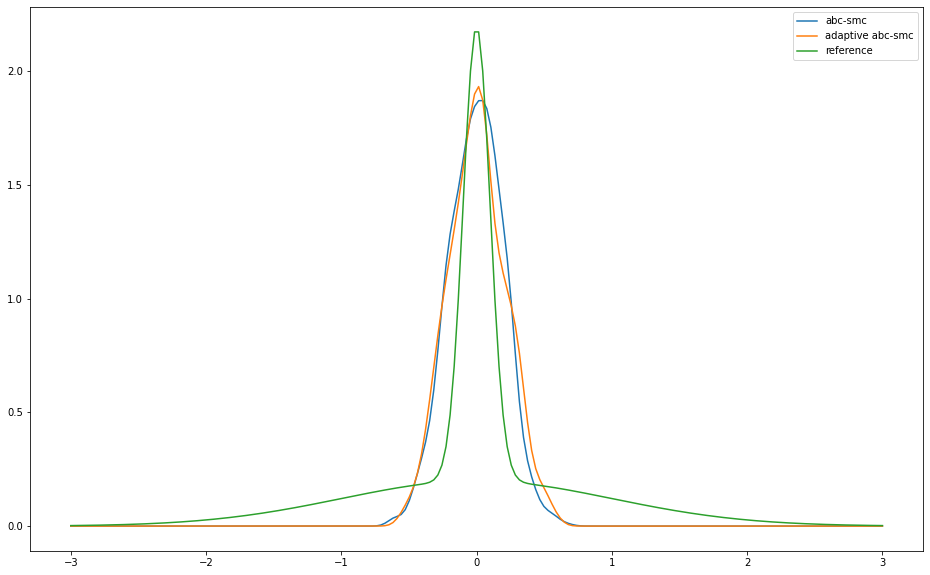

In [19]:
#Confrontiamo i nostri risultati con la posteriori teorica
smc_posteriorpdf = gaussian_kde(result_smc.samples_array[:,0])
adaptive_smc_posteriorpdf = gaussian_kde(adaptive_smc_samples.samples_array[:,0])
reference_posteriorpdf = gaussian_mixture_density

xs = np.linspace(-3,3,200)
smc_posteriorpdf.covariance_factor = lambda : .25
smc_posteriorpdf._compute_covariance()
adaptive_smc_posteriorpdf.covariance_factor = lambda : .25
adaptive_smc_posteriorpdf._compute_covariance()
plt.figure(figsize=(16,10))
plt.plot(xs,smc_posteriorpdf(xs))
plt.plot(xs,adaptive_smc_posteriorpdf(xs))
plt.plot(xs,reference_posteriorpdf(xs))
plt.legend(('abc-smc', 'adaptive abc-smc', 'reference'));

In [20]:
#Sequential Monte Carlo con distanza adattiva
d.become(elfi.AdaptiveDistance(Y))

In [21]:
ada_smc = elfi.AdaptiveDistanceSMC(d, batch_size=1000, seed=seed)

In [22]:
sample_ada = ada_smc.sample(1000, 3, quantile=0.01)

INFO:elfi.methods.inference.samplers:---------------- Starting round 0 ----------------


ABC-SMC Round 1 / 3
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.samplers:---------------- Starting round 1 ----------------


ABC-SMC Round 2 / 3
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.samplers:---------------- Starting round 2 ----------------


ABC-SMC Round 3 / 3
Progress [==================================================] 100.0% Complete


In [23]:
sample_ada

Method: AdaptiveDistanceSMC
Number of samples: 1000
Number of simulations: 52751000
Threshold: 1.21
Sample means: t1: -0.023

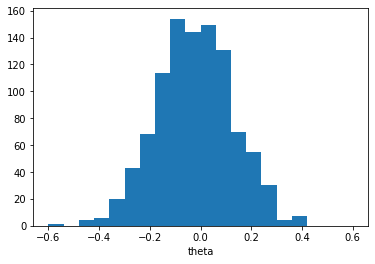

In [24]:
plt.hist(sample_ada.samples_array,range=(-0.6,0.6),bins=20)
plt.xlabel('theta');

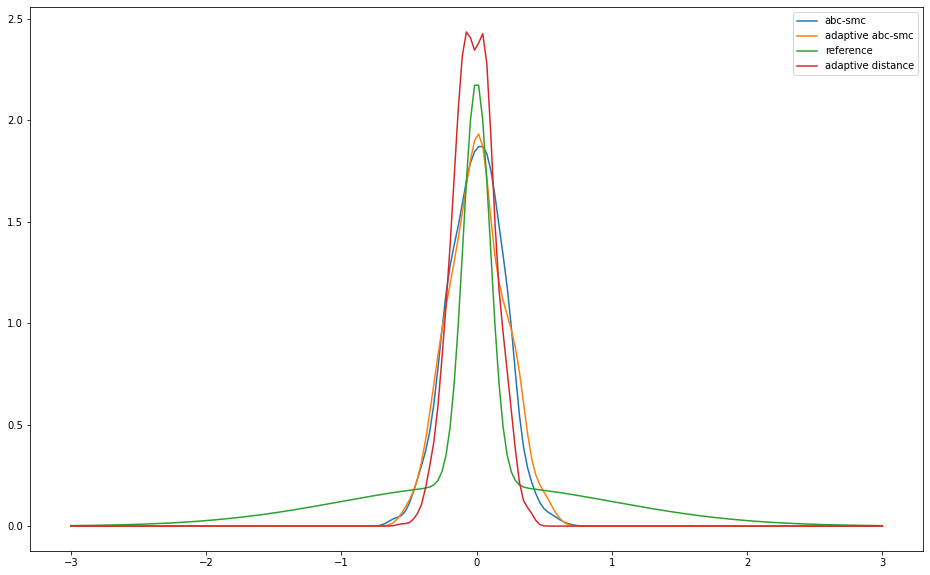

In [25]:
#Confrontiamo ancora una volta con la posteriori teorica
smc_posteriorpdf = gaussian_kde(result_smc.samples_array[:,0])
adaptive_smc_posteriorpdf = gaussian_kde(adaptive_smc_samples.samples_array[:,0])
sample_ada_posteriorpdf = gaussian_kde(sample_ada.samples_array[:,0])

reference_posteriorpdf = gaussian_mixture_density

xs = np.linspace(-3,3,200)
smc_posteriorpdf.covariance_factor = lambda : .25
smc_posteriorpdf._compute_covariance()
adaptive_smc_posteriorpdf.covariance_factor = lambda : .25
adaptive_smc_posteriorpdf._compute_covariance()
sample_ada_posteriorpdf.covariance_factor = lambda : .25
sample_ada_posteriorpdf._compute_covariance()
plt.figure(figsize=(16,10))
plt.plot(xs,smc_posteriorpdf(xs))
plt.plot(xs,adaptive_smc_posteriorpdf(xs))
plt.plot(xs,reference_posteriorpdf(xs))
plt.plot(xs,sample_ada_posteriorpdf(xs))
plt.legend(('abc-smc', 'adaptive abc-smc', 'reference','adaptive distance'));